# Meta Motivo Tutorial
This notebook provides a simple introduction on how to use the Meta Motivo api.

## All imports

In [1]:
from packaging.version import Version
from metamotivo.fb_cpr.huggingface import FBcprModel
from huggingface_hub import hf_hub_download
from humenv import make_humenv
import gymnasium
from gymnasium.wrappers import FlattenObservation, TransformObservation
from metamotivo.buffers.buffers import DictBuffer
from humenv.env import make_from_name
from humenv import rewards as humenv_rewards

import torch
import mediapy as media
import math
import h5py
from pathlib import Path
import numpy as np
import time

import os
from ruamel.yaml import YAML, dump, RoundTripDumper
from raisimGymTorch.env.bin import motivo_env
from raisimGymTorch.env.RaisimGymVecEnv import RaisimGymVecEnv as VecEnv

/home/oem/anaconda3/envs/metamotivo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
home_path = os.getcwd()
task_path = home_path + "/raisimGymTorch/env/envs/motivo_env"

cfg = YAML().load(open(task_path + "/cfg.yaml", 'r'))
cfg['environment']['num_envs'] = 1

class config:
  motions_root: str = ""
  motions: str = ""

custom_config = config()
custom_config.motions_root = "/home/oem/workspace/metamotivo/humenv_amass"
custom_config.motions = "/home/oem/workspace/metamotivo/examples/test_train_split/example.txt"

env_raisim = VecEnv(motivo_env.RaisimGymEnv(home_path + "/rsc", dump(cfg['environment'], Dumper=RoundTripDumper)), custom_config)

ob_dim = env_raisim.num_obs
act_dim = env_raisim.num_acts
print(ob_dim, act_dim)

358 69


## Model download
The first step is to download the model. We show how to use HuggingFace hub for that.

In [3]:
model = FBcprModel.from_pretrained("facebook/metamotivo-S-1")
# print(model)

**Run a policy from Meta Motivo:**

Now that we saw how to load a pre-trained Meta Motivo policy, we can prompt it and execute actions with it. 

The first step is to sample a context embedding `z` that needs to be passed to the policy.

In [4]:
device = "cpu"

if Version("0.26") <= Version(gymnasium.__version__) < Version("1.0"):
    transform_obs_wrapper = lambda env: TransformObservation(
            env, lambda obs: torch.tensor(obs.reshape(1, -1), dtype=torch.float32, device=device)
        )
else:
    transform_obs_wrapper = lambda env: TransformObservation(
            env, lambda obs: torch.tensor(obs.reshape(1, -1), dtype=torch.float32, device=device), env.observation_space
        )

env, _ = make_humenv(
    num_envs=1,
    wrappers=[
        FlattenObservation,
        transform_obs_wrapper,
    ],
    state_init="Default",
)

model.to(device)
z = model.sample_z(1)
print(f"embedding size {z.shape}")
print(f"z norm: {torch.norm(z)}")
print(f"z norm / sqrt(d): {torch.norm(z) / math.sqrt(z.shape[-1])}")
observation, _ = env.reset()
print(f"observation size : {observation.shape}")

embedding size torch.Size([1, 256])
z norm: 16.0
z norm / sqrt(d): 1.0
observation size : torch.Size([1, 358])


In [5]:
observation, _ = env.reset()
frames = [env.render()]
for i in range(30):
    action = model.act(observation, z, mean=True)
    observation, reward, terminated, truncated, info = env.step(action.cpu().numpy().ravel())
    frames.append(env.render())
    # print(observation)

media.show_video(frames, fps=30)

In [49]:
env_raisim.reset()
gc = env_raisim.observe_gc()
print(gc)

td, info = env_raisim.observe(False)
observation_raisim = torch.from_numpy(td["obs"])

for i in range(30):
    start_time = time.time()
    action = model.act(observation_raisim, z, mean=True)
    env_raisim.step(action.cpu().numpy())
    td, info = env_raisim.observe(False)
    observation_raisim = torch.from_numpy(td["obs"])
    time.sleep(0.033)


[[-1.92264151e-02  5.58260549e-03  9.58782613e-01 -7.59859562e-01
  -2.44293049e-01 -2.47579634e-01 -5.49216449e-01 -2.14785971e-02
   2.19877474e-02  5.30252978e-02  1.24042936e-01  1.56587921e-03
  -1.18472420e-01  1.12031713e-01 -8.36486518e-02 -7.00314017e-03
  -1.19747296e-01 -1.93008929e-02  4.42980696e-03 -1.34615377e-02
   4.40355316e-02 -1.68780848e-01  1.79976802e-02  6.09588847e-02
   1.25837728e-01  1.61079854e-01  4.36018296e-02  1.11216167e-02
  -1.17446609e-01  1.01207383e-02  8.85472109e-05  9.95901302e-02
  -8.04519467e-03  1.22635886e-02  6.43217787e-02  3.97954695e-02
  -3.15191671e-02  1.22835755e-01  9.95407254e-02 -8.18383396e-02
   1.22056209e-01 -3.34679335e-02  1.59357004e-02 -7.16766790e-02
   2.44402178e-02 -6.42946139e-02 -9.74311307e-02  4.64284830e-02
   8.11733231e-02  4.80191931e-02 -8.27387795e-02 -1.57555658e-02
  -1.02545425e-01 -1.27393082e-01 -1.26939446e-01 -1.23458810e-01
  -5.07152006e-02 -8.09633881e-02  1.15385745e-02  2.46632621e-02
  -6.75803

### Computing Q-functions

FB-CPR provides a way of directly computing the action-value function of any policy embedding `z` on any task embedding `z_r`. Then, the Q function of a policy $z$ is given by

$Q(s,a, z) = F(s,a,z) \cdot z_r$

The task embedding can be computed in the following way. Given a set of samples labeled with rewards $(s,a,s',r)$, the task embedding is given by: 

$z_r = \mathrm{normalised}(\sum_{i \in \mathrm{batch}} r_i B(s'_i))$.

In [7]:
def Qfunction(state, action, z_reward, z_policy):
    F = model.forward_map(obs=state, z=z_policy.repeat(state.shape[0],1), action=action) # num_parallel x num_samples x z_dim
    Q = F @ z_reward.ravel()
    return Q.mean(axis=0)

z_reward = model.sample_z(1)
z_policy = model.sample_z(1)
state = torch.rand((10, env.observation_space.shape[0]), device=model.cfg.device, dtype=torch.float32)
action = torch.rand((10, env.action_space.shape[0]), device=model.cfg.device, dtype=torch.float32)*2 - 1
Q = Qfunction(state, action, z_reward, z_policy)
print(Q)

tensor([  15.8997,  -24.7993, -230.5503,  -62.9668,   69.7152, -127.8584,
          -2.1978,   26.7395,  190.0372,  160.6691])


## Prompting the model

We have seen that we can condition the model via the context variable `z`. We can control the task to execute via _prompting_ (or _policy inference_).

### Reward prompts
The first version of inference we investigate is the reward prompting, i.e., given a set of reward label samples we can infer in a zero-shot way the near-optimal policy for solving such task.

First step, download the data for inference. We provide a buffer for inference of about 500k samples. This buffer has been generated by randomly subsampling the final replay buffer.

In [8]:
local_dir = "metamotivo-S-1-datasets"
dataset = "buffer_inference_500000.hdf5"
buffer_path = hf_hub_download(
        repo_id="facebook/metamotivo-S-1",
        filename=f"data/{dataset}",
        repo_type="model",
        local_dir=local_dir,
    )
print(buffer_path)

metamotivo-S-1-datasets/data/buffer_inference_500000.hdf5


Now that we have download the h5 file for inference, we can conveniently loaded it in a buffer.

In [9]:
hf = h5py.File(buffer_path, "r")
print(hf.keys())
data = {}
for k, v in hf.items():
    print(f"{k:20s}: {v.shape}")
    data[k] = v[:]
buffer = DictBuffer(capacity=data["qpos"].shape[0], device="cpu")
buffer.extend(data)
del data

<KeysViewHDF5 ['action', 'next_observation', 'next_qpos', 'next_qvel', 'observation', 'qpos', 'qvel']>
action              : (500000, 69)
next_observation    : (500000, 358)
next_qpos           : (500000, 76)
next_qvel           : (500000, 75)
observation         : (500000, 358)
qpos                : (500000, 76)
qvel                : (500000, 75)


In [10]:
batch = buffer.sample(5)
for k, v in batch.items():
    print(f"{k:20s}: {v.shape}")

action              : torch.Size([5, 69])
next_observation    : torch.Size([5, 358])
next_qpos           : torch.Size([5, 76])
next_qvel           : torch.Size([5, 75])
observation         : torch.Size([5, 358])
qpos                : torch.Size([5, 76])
qvel                : torch.Size([5, 75])


As you can see, the buffer does not provide a reward signal. We need to label this buffer with the desired reward function. We provide API for that but here we start looking into the basic steps:
* Instantiate a reward function
* Computing the reward from the batch data

In [11]:
reward_fn = humenv_rewards.LocomotionReward(move_speed=2.0) # move ahead with speed 2
# humenv provides also a name-base reward initialization. We could
# get the same reward function in this way
reward_fn = make_from_name("move-ego-0-2") 
print(reward_fn)

LocomotionReward(move_speed=2.0, stand_height=1.4, move_angle=0.0, egocentric_target=True, low_height=0.6, stay_low=False)


We can call the method `__call__` to obtain a reward value from the physics state. This function receives a mujoco model, qpos, qvel and the action. See the humenv tutorial for more information.

In [12]:
N = 100_000
batch = buffer.sample(N)
rewards = []
for i in range(N):
    rewards.append(
        reward_fn(
            env.unwrapped.model,
            qpos=batch["next_qpos"][i],
            qvel=batch["next_qvel"][i],
            ctrl=batch["action"][i])
    )
rewards = np.stack(rewards).reshape(-1,1)
print(rewards.ravel())

[0.63164384 0.1871349  0.14196779 ... 0.50814383 0.00064555 0.09299892]


**Note** that the reward functions implemented in humenv are functions of next state and action which means we need to use `next_qpos` and `next_qvel` that are the physical state of the system at the next state.

We provide a multi-thread version for faster relabeling, see `metamotivo.wrappers.humenvbench.relabel`.

In [13]:
from metamotivo.wrappers.humenvbench import relabel
rewards = relabel(
    env,
    qpos=batch["next_qpos"],
    qvel=batch["next_qvel"],
    action=batch["action"],
    reward_fn=reward_fn, 
    max_workers=8
)
print(rewards.ravel())

[0.63164384 0.1871349  0.14196779 ... 0.50814383 0.00064555 0.09299892]


We can now infer the context `z` for the selected task.

In [52]:
z = model.reward_wr_inference(
    next_obs=batch["next_observation"],
    reward=torch.tensor(rewards, device=model.cfg.device, dtype=torch.float32)
)
print(z.shape)

observation, _ = env.reset()
frames = [env.render()]
for i in range(30):
    action = model.act(observation, z, mean=True)
    observation, reward, terminated, truncated, info = env.step(action.cpu().numpy().ravel())
    frames.append(env.render())

media.show_video(frames, fps=30)

torch.Size([1, 256])


In [59]:
env_raisim.reset()
td, info = env_raisim.observe(False)
observation_raisim = torch.from_numpy(td["obs"])

for i in range(30):
    start_time = time.time()
    action = model.act(observation_raisim, z, mean=True)
    env_raisim.step(action.cpu().numpy())
    td, info = env_raisim.observe(False)
    observation_raisim = torch.from_numpy(td["obs"])
    time.sleep(0.033)


Let's compute the **Q-function** for this policy.

In [16]:
z_reward = torch.sum(
    model.backward_map(obs=batch["next_observation"]) * torch.tensor(rewards, dtype=torch.float32, device=model.cfg.device),
    dim=0
)
z_reward = model.project_z(z_reward)
Q = Qfunction(batch["observation"], batch["action"], z_reward, z)
print(Q)

tensor([4374.1602, 4556.1831, 4512.2822,  ..., 4151.4883, 4390.2700,
        4328.8838])


# Goal and Tracking prompts
The model supports two other modalities, `goal` and `tracking`. These two modalities expose similar functions for context inference:
- `def goal_inference(self, next_obs: torch.Tensor) -> torch.Tensor`
- `def tracking_inference(self, next_obs: torch.Tensor) -> torch.Tensor`
  
We show an example on how to perform goal inference.

goal pose


""

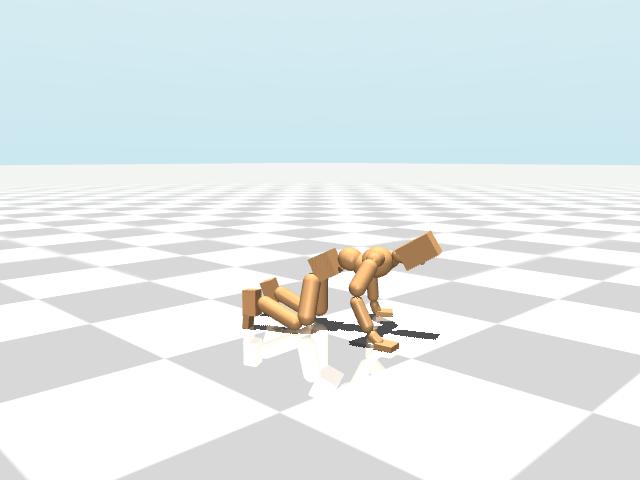

In [17]:
goal_qpos = np.array([0.13769039,-0.20029453,0.42305034,0.21707786,0.94573617,0.23868944
,0.03856998,-1.05566834,-0.12680767,0.11718296,1.89464102,-0.01371153
,-0.07981451,-0.70497424,-0.0478,-0.05700732,-0.05363342,-0.0657329
,0.08163511,-1.06263979,0.09788937,-0.22008936,1.85898192,0.08773695
,0.06200327,-0.3802791,0.07829525,0.06707749,0.14137152,0.08834448
,-0.07649805,0.78328658,0.12580912,-0.01076061,-0.35937259,-0.13176489
,0.07497022,-0.2331914,-0.11682692,0.04782308,-0.13571422,0.22827948
,-0.23456622,-0.12406075,-0.04466465,0.2311667,-0.12232673,-0.25614032
,-0.36237662,0.11197906,-0.08259534,-0.634934,-0.30822742,-0.93798716
,0.08848668,0.4083417,-0.30910404,0.40950143,0.30815359,0.03266103
,1.03959336,-0.19865537,0.25149713,0.3277561,0.16943092,0.69125975
,0.21721349,-0.30871948,0.88890484,-0.08884043,0.38474549,0.30884107
,-0.40933304,0.30889523,-0.29562966,-0.6271498])
env.unwrapped.set_physics(qpos=goal_qpos, qvel=np.zeros(75))
goal_obs = torch.tensor(env.unwrapped.get_obs()["proprio"].reshape(1,-1), device=model.cfg.device, dtype=torch.float32)
print("goal pose")
media.show_image(env.render())

In [20]:
z = model.tracking_inference(next_obs=goal_obs)


observation, _ = env.reset()

frames = [env.render()]
for i in range(30):
    action = model.act(observation, z, mean=True)
    observation, reward, terminated, truncated, info = env.step(action.cpu().numpy().ravel())
    frames.append(env.render())

media.show_video(frames, fps=30)

tensor([[ 9.4000e-01, -6.8000e-03,  6.9500e-02, -9.1400e-02, -1.1300e-02,
          1.0380e-01, -4.6660e-01, -5.5000e-02,  9.0200e-02, -8.6460e-01,
          6.4300e-02,  1.1660e-01, -9.2040e-01, -4.3000e-03, -6.7700e-02,
         -9.0500e-02, -1.3200e-02, -1.0600e-01, -4.7310e-01, -5.5500e-02,
         -9.0200e-02, -8.7150e-01,  6.7800e-02, -1.1560e-01, -9.1960e-01,
         -2.6700e-02, -2.5000e-03,  1.0900e-01, -2.5600e-02,  3.0000e-03,
          2.4420e-01, -2.0000e-04,  4.5000e-03,  2.9710e-01, -4.3100e-02,
          1.7000e-03,  5.1100e-01,  8.2000e-03,  6.9000e-03,  5.7600e-01,
         -3.4300e-02,  8.3300e-02,  4.1880e-01, -4.3200e-02,  1.7430e-01,
          4.4930e-01, -7.0700e-02,  4.3390e-01,  4.3650e-01, -7.1900e-02,
          6.8310e-01,  4.4550e-01, -8.6800e-02,  7.6710e-01,  4.3730e-01,
         -3.8800e-02, -7.7300e-02,  4.1590e-01, -4.7900e-02, -1.7330e-01,
          4.4850e-01, -6.9300e-02, -4.2700e-01,  4.3520e-01, -7.4900e-02,
         -6.8230e-01,  4.4300e-01, -8.

In [48]:
env_raisim.reset()
obs = env_raisim.observe(False)
observation_raisim = torch.from_numpy(obs)

for i in range(30):
    action = model.act(observation_raisim, z, mean=True)
    env_raisim.step(action.cpu().numpy())
    obs = env_raisim.observe(False)
    observation_raisim = torch.from_numpy(obs)
    time.sleep(0.033)

TypeError: expected np.ndarray (got tuple)

In [74]:
from gymnasium.wrappers import TimeAwareObservation

env, _ = make_humenv(
    num_envs=1,
    # vectorization_mode="sync",
    wrappers=[
                gymnasium.wrappers.FlattenObservation,
                lambda env: TimeAwareObservation(env, flatten=False),
            ],
    state_init="Fall",
    autoreset_mode="next_step"
)


TypeError: HumEnv.__init__() got an unexpected keyword argument 'autoreset_mode' was raised from the environment creator for humenv/HumEnv-v0.0.1 with kwargs ({'motion_buffer': None, 'state_init': 'Fall', 'autoreset_mode': 'next_step', 'motion_base_path': None})

In [75]:
observation, _ = env.reset()

frames = [env.render()]
for i in range(305):
    action = torch.randn((1, 69))
    observation, reward, terminated, truncated, info = env.step(action.cpu().numpy().ravel())
    if truncated:
        print("truncated occurred!")
    else:
        print("normal step")
    frames.append(env.render())

media.show_video(frames, fps=30)

normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
normal step
norm